In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

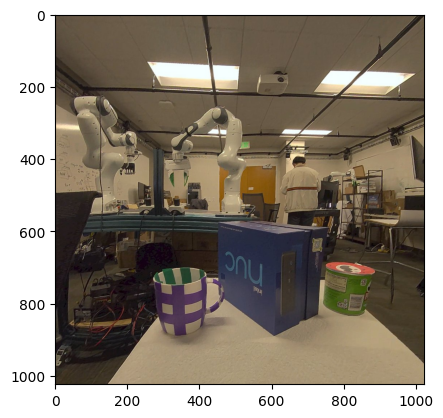

In [2]:
color_images = cv2.imread('ColorMap8.jpg')
plt.imshow(cv2.cvtColor(color_images, cv2.COLOR_BGR2RGB))

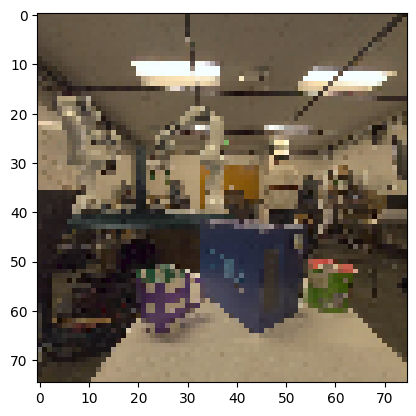

In [3]:
# Downsample to 100x100
color_downsampled = cv2.resize(color_images, (75, 75))
plt.imshow(cv2.cvtColor(color_downsampled, cv2.COLOR_BGR2RGB))

In [4]:
import struct
def read_floats_from_binary_file(file_path):
    floats = []
    with open(file_path, 'rb') as file:
        # Read the number of floats stored in the first 4 bytes
        num_floats = struct.unpack('I', file.read(4))[0]  # 'I' is for unsigned int
        
        # Read each float one by one
        for _ in range(num_floats):
            float_data = file.read(4)  # Size of a float in bytes
            if float_data:
                floats.append(struct.unpack('f', float_data)[0])  # 'f' is for float

    return floats

True

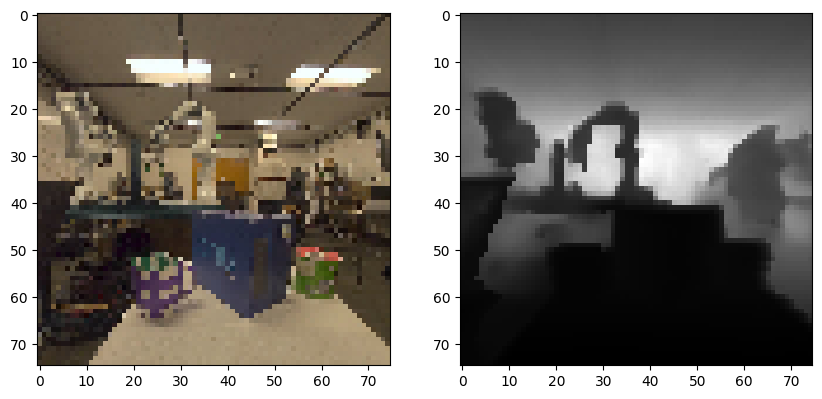

In [14]:
raw_depth = np.array(read_floats_from_binary_file('DepthMap8.bin')[:10000]).reshape(100, 100)
cropped_depth = np.flip(raw_depth, 0)[3:78,25:]  # Flip the image vertically
# Shows depth and colored image side by side
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(color_downsampled, cv2.COLOR_BGR2RGB))
plt.subplot(1, 2, 2)
plt.imshow(cropped_depth, cmap='gray')

# Convert to grayscale and save Depth image
cv2.imwrite('DepthMap111.jpg', raw_depth * 255)

In [10]:
import open3d as o3d

h_factor = 0.79
v_factor = 0.83
# Need to based on the assumption that each pixel is uniformly spaced
def depth_to_pointcloud_naive(depth_image, fovLeft=1.176382 * h_factor, fovRight=0.9390996 * h_factor, fovUp=0.9656888 * v_factor, fovDown=1.028148 * v_factor):
    height, width = depth_image.shape
    # Calculate the new principal point based on the shifts
    cx = width * np.tan(fovLeft) / (np.tan(fovLeft) + np.tan(fovRight))
    cy = height * np.tan(fovUp) / (np.tan(fovUp) + np.tan(fovDown))

    # Convert depth image to actual distances (0 to 3 meters)
    depth = depth_image

    # Calculate focal lengths based on field of view
    f_x = cx / np.tan(fovLeft)
    f_y = cy / np.tan(fovUp)
    print(cx, cy)
    # Generate meshgrid for pixel coordinates
    u, v = np.meshgrid(np.arange(width), np.arange(height))
    
    # Transform meshgrid to camera coordinates
    x = (u - cx) * depth / f_x
    y = (v - cy) * depth / f_y
    z = depth
    
    # Flatten arrays
    x = x.flatten()
    y = y.flatten()
    z = z.flatten()

    # Stack into point cloud
    point_cloud = np.vstack((x, z, y)).T
    
    return point_cloud


Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


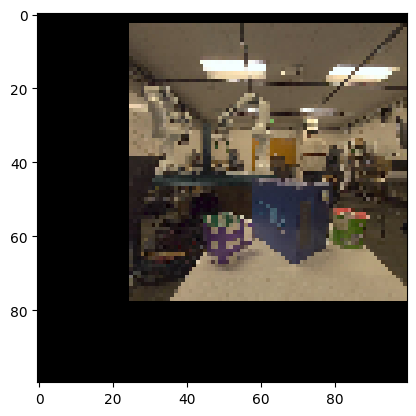

In [17]:
# Add padding to RGB image on left and bottom dim0: 0:3, 82:100, dim1: 0:25
color_padded = np.pad(color_downsampled, ((3, 22), (25, 0), (0, 0)), mode='constant')
# show padded image
plt.imshow(cv2.cvtColor(color_padded, cv2.COLOR_BGR2RGB))
color_padded = np.flip(color_padded, 0)

In [23]:
points = depth_to_pointcloud_naive(raw_depth)
colors = color_padded.reshape(-1, 3) / 255
pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(points)
pcd.colors = o3d.utility.Vector3dVector(colors[:, [2, 1, 0]])
o3d.visualization.draw_geometries([pcd])

59.36505376488384 47.39991711631259


In [24]:
cropped = pcd.crop(o3d.geometry.AxisAlignedBoundingBox(min_bound=(-1, 0, -1), max_bound=(1, 0.5, 1)))
o3d.visualization.draw_geometries([cropped])

[Open3D WARNING] [ViewControl] SetViewPoint() failed because window height and width are not set.
